# Stock price prediction using LSTM with PyTorch

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
microsoft_ticker = 'MSFT'
df = yf.download(microsoft_ticker, period='5y')
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2020-04-27,166.596985,169.324936,165.879101,169.028213,33194400
2020-04-28,162.538498,168.147565,162.136485,168.070989,34392700
2020-04-29,169.832214,170.071509,164.519884,165.802500,51286600
2020-04-30,171.536011,172.675041,168.683608,172.292176,53875900
2020-05-01,167.094696,170.990406,166.558664,168.272022,39370500


<Axes: xlabel='Date'>

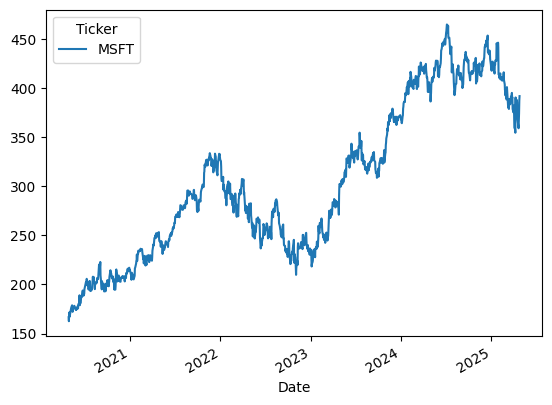

In [ ]:
df['Close'].plot()

In [ ]:
sc = StandardScaler()
df['Close'] = sc.fit_transform(df['Close'].values.reshape(-1, 1))
df['Close']

Ticker,MSFT
Date,
2020-04-27,-1.742204
2020-04-28,-1.793791
2020-04-29,-1.701082
2020-04-30,-1.679425
2020-05-01,-1.735878
...,...
2025-04-21,0.704922
2025-04-22,0.802796
2025-04-23,0.899017


In [ ]:
seq_length = 45
data = []

for i in range(len(df) - seq_length):
    data.append(df['Close'][i:i+seq_length])

data = np.array(data)

In [ ]:
train_size = int(len(data) * 0.8)

X_train = torch.from_numpy(data[:train_size, :-1]).float().to(device)
y_train = torch.from_numpy(data[:train_size, -1]).float().to(device)
X_test = torch.from_numpy(data[train_size:, :-1]).float().to(device)
y_test = torch.from_numpy(data[train_size:, -1]).float().to(device)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([969, 44, 1])
torch.Size([969, 1])
torch.Size([243, 44, 1])
torch.Size([243, 1])


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.3):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)

        self.batch_norm = nn.BatchNorm1d(hidden_size)

        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = out[:, -1, :]

        out = self.batch_norm(out)
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [ ]:
model = LSTMModel(input_size=1, hidden_size=64, num_layers=2, output_size=1).to(device)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 300

for epoch in range(1, num_epochs+1):
    y_train_pred = model(X_train)
    loss = loss_fn(y_train_pred, y_train)
    if epoch % 20 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  20  loss:  0.11754702776670456
epoch:  40  loss:  0.058313049376010895
epoch:  60  loss:  0.04133784398436546
epoch:  80  loss:  0.04569574445486069
epoch:  100  loss:  0.0340145044028759
epoch:  120  loss:  0.03407742828130722
epoch:  140  loss:  0.03317234292626381
epoch:  160  loss:  0.03324354439973831
epoch:  180  loss:  0.029670562595129013
epoch:  200  loss:  0.030176697298884392
epoch:  220  loss:  0.033467721194028854
epoch:  240  loss:  0.031246516853570938
epoch:  260  loss:  0.028913697227835655
epoch:  280  loss:  0.03140990063548088
epoch:  300  loss:  0.029490536078810692


In [ ]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = loss_fn(y_test_pred, y_test)
    print('Test Loss: ', test_loss.item())

Test Loss:  0.01554117165505886


In [ ]:
y_train = sc.inverse_transform(y_train.cpu().detach().numpy())
y_test = sc.inverse_transform(y_test.cpu().detach().numpy())
y_train_pred = sc.inverse_transform(y_train_pred.cpu().detach().numpy())
y_test_pred = sc.inverse_transform(y_test_pred.cpu().detach().numpy())

In [ ]:
print(y_train.shape)
print(y_test.shape)
print(y_train_pred.shape)
print(y_test_pred.shape)

(969, 1)
(243, 1)
(969, 1)
(243, 1)


In [ ]:
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print('Train RMSE: ', train_rmse)
print('Test RMSE: ', test_rmse)

Train RMSE:  13.510380744934082
Test RMSE:  9.807720184326172


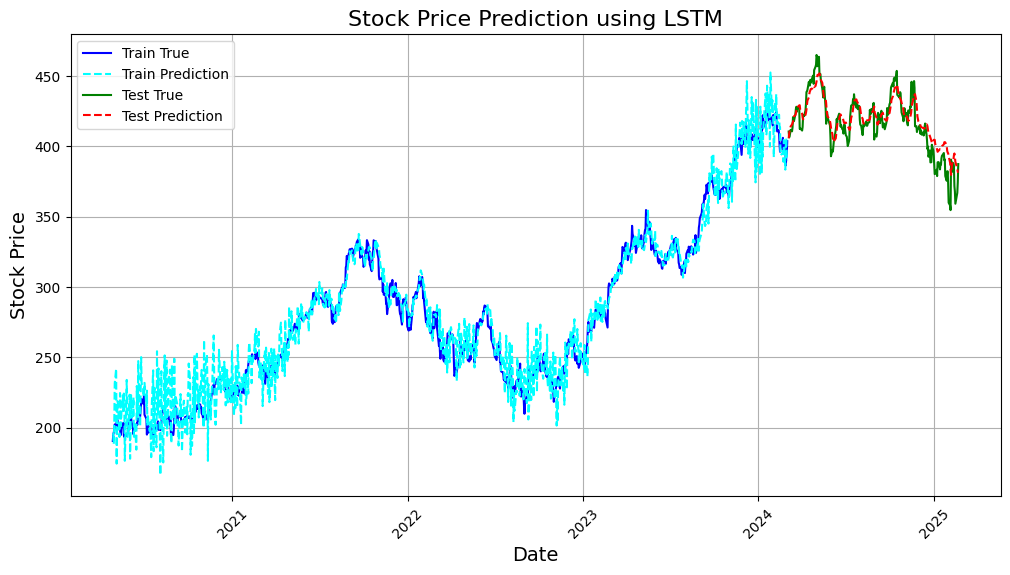

In [ ]:
plt.figure(figsize=(12, 6))

train_dates = df.index[:train_size].to_pydatetime()
test_dates = df.index[train_size:train_size+len(y_test)].to_pydatetime()

plt.plot(train_dates, y_train, label='Train True', color='blue')
plt.plot(train_dates, y_train_pred, label='Train Prediction', color='cyan', linestyle='--')

plt.plot(test_dates, y_test, label='Test True', color='green')
plt.plot(test_dates, y_test_pred, label='Test Prediction', color='red', linestyle='--')

plt.title('Stock Price Prediction using LSTM', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()